## Load dataset

In [1]:
import numpy as np

from keras import backend as K

np.random.seed(42)

/home/paperspace/anaconda3/envs/capstone/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

n_training_examples = x_train.shape[0]
n_testing_examples = x_test.shape[0]
print('Training data shape: {}'.format(x_train.shape))
print('Number of training examples: {}'.format(n_training_examples))
print('Number of testing examples: {}'.format(n_testing_examples))

Training data shape: (50000, 32, 32, 3)
Number of training examples: 50000
Number of testing examples: 10000


## Set hyperparameters

In [3]:
batch_size = 16
n_epochs = 30
n_classes = 20

## Preprocessing

In [4]:
import keras.utils as k_utils

Y_train = k_utils.to_categorical(y_train, n_classes)
Y_test = k_utils.to_categorical(y_test, n_classes)

print('Y_train shape: {}'.format(Y_train.shape))

Y_train shape: (50000, 20)


## Data generator

In [5]:
from keras.applications.resnet50 import preprocess_input
import cv2

def image_generator(images, labels):
    def generator():
        start = 0
        end = batch_size
        n = len(images)
        while True:
            img_batch_resized = np.array([cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) for img in images[start:end]])
            img_batch_resized = img_batch_resized.astype('float32')
            img_batch_preprocessed = preprocess_input(img_batch_resized)
            label_batch = labels[start:end]
            
            start += batch_size
            end += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (img_batch_preprocessed, label_batch)
    return generator

## Pre-trained model

In [6]:
from keras.applications.resnet50 import ResNet50
pretrained_model = ResNet50(weights='imagenet', include_top=False)

## Extract features

In [7]:
import os

if os.path.exists('bottleneck_features_train_coarse.npy'):
    bottleneck_features_training = np.load(open('bottleneck_features_train_coarse.npy', 'rb'))
else:
    train_datagen = image_generator(x_train, Y_train)
    bottleneck_features_training = pretrained_model.predict_generator(train_datagen(), n_training_examples//batch_size)
    np.save(open('bottleneck_features_train_coarse.npy', 'wb'), bottleneck_features_training)

In [8]:
if os.path.exists('bottleneck_features_validation_coarse.npy'):
    bottleneck_features_testing = np.load(open('bottleneck_features_validation_coarse.npy', 'rb'))
else:
    test_datagen = image_generator(x_test, Y_test)
    bottleneck_features_testing = pretrained_model.predict_generator(test_datagen(), n_testing_examples//batch_size)
    np.save(open('bottleneck_features_validation_coarse.npy', 'wb'), bottleneck_features_testing)

In [9]:
print('Training features shape: {}'.format(bottleneck_features_training.shape))
print('Testing features shape: {}'.format(bottleneck_features_testing.shape))

Training features shape: (50000, 1, 1, 2048)
Testing features shape: (10000, 1, 1, 2048)


In [10]:
pretrained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Define model

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_training.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

## Compile model

In [12]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                20500     
Total params: 2,118,676
Trainable params: 2,118,676
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [14]:
train_datagen = image_generator(x_train, Y_train)
test_datagen = image_generator(x_test, Y_test)

history = model.fit(bottleneck_features_training, Y_train, 
          epochs=n_epochs,
          batch_size=batch_size,
          validation_data=(bottleneck_features_testing, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 15s 305us/step - loss: 1.3376 - acc: 0.5826 - val_loss: 0.7776 - val_acc: 0.7462
Epoch 2/30
50000/50000 [==============================] - 15s 294us/step - loss: 0.8238 - acc: 0.7347 - val_loss: 0.6834 - val_acc: 0.7775
Epoch 3/30
50000/50000 [==============================] - 15s 298us/step - loss: 0.7209 - acc: 0.7657 - val_loss: 0.6432 - val_acc: 0.7915
Epoch 4/30
50000/50000 [==============================] - 15s 294us/step - loss: 0.6587 - acc: 0.7876 - val_loss: 0.6207 - val_acc: 0.7985
Epoch 5/30
50000/50000 [==============================] - 15s 293us/step - loss: 0.6166 - acc: 0.8008 - val_loss: 0.6051 - val_acc: 0.8032
Epoch 6/30
50000/50000 [==============================] - 15s 293us/step - loss: 0.5829 - acc: 0.8125 - val_loss: 0.5855 - val_acc: 0.8109
Epoch 7/30
50000/50000 [==============================] - 14s 289us/step - loss: 0.5617 - acc: 0.8208 - val_loss: 0.

## Save model

In [15]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'tl_20_model.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/paperspace/capstone/saved_models/tl_20_model.h5 


## Test accuracy

In [16]:
scores = model.evaluate(bottleneck_features_testing, Y_test, batch_size=batch_size)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

10000/10000 [==============================] - 1s 87us/step

acc: 84.87%


## Plot accuracy and loss

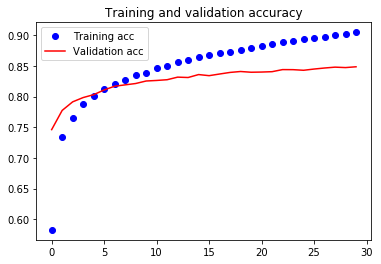

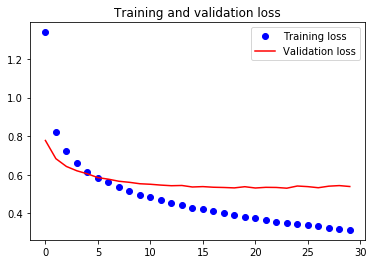

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

References
- https://keras.io/applications/
- The Keras Blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb
- Learn OpenCV https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/
- Cifar10 classification experiments https://github.com/rnoxy/cifar10-cnn